In [2]:

import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

with open("../data/raw/fixtures.json") as f:
    raw_data = json.load(f)

fixtures = raw_data["response"]

df = pd.json_normalize(fixtures)

In [ ]:
df_games = df[["league.round","teams.home.name","teams.away.name","teams.home.winner","teams.away.winner"]].copy()
df_games["round"] = df_games["league.round"].str.extract(r"(\d+)").astype(int)

scores = []

for idx, row in df_games.iterrows():
    round = row["round"]
    home_team = row["teams.home.name"]
    home_result = row["teams.home.winner"]
    away_team = row["teams.away.name"]
   away_result = row["t eams.away.winner"]

    home_point = 1
    away_point = 1

    if home_result == True:
        home_point = 3
        away_point = 0
    elif home_result == False:
        home_point = 0
        away_point = 3

    scores.append({"team":home_team,"round":round,"result":home_point})
    scores.append({"team":away_team,"round":round,"result":away_point})

df_round_points = pd.DataFrame(scores)
df_round_points = df_round_points.sort_values(by=["team","round"])

df_round_points["accumulated"] = df_round_points.groupby("team")["result"].cumsum()





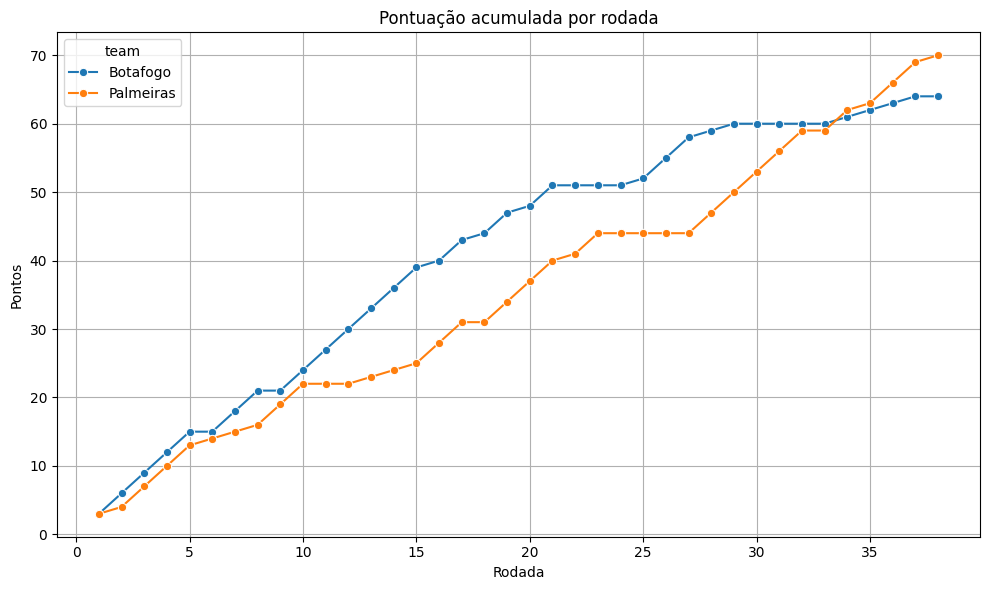

In [22]:
teams = ["Palmeiras","Botafogo"]
df_comparation = df_round_points[df_round_points["team"].isin(teams)]

plt.figure(figsize=(10,6))
sns.lineplot(data=df_comparation, x="round", y="accumulated", hue="team", marker="o")
plt.title("Pontuação acumulada por rodada")
plt.xlabel("Rodada")
plt.ylabel("Pontos")
plt.grid(True)
plt.tight_layout()
plt.show()

In [4]:
df_goals = df[["league.round","goals.home","goals.away"]].copy()

df_goals["total_goals"] = df["goals.home"] + df["goals.away"]

df_round_goals = df_goals.groupby("league.round")["total_goals"].sum().reset_index()

#ordenação por rodada
df_round_goals["rodada_num"] = df_round_goals["league.round"].str.extract(r"(\d+)").astype(int)
df_round_goals = df_round_goals.sort_values("rodada_num")

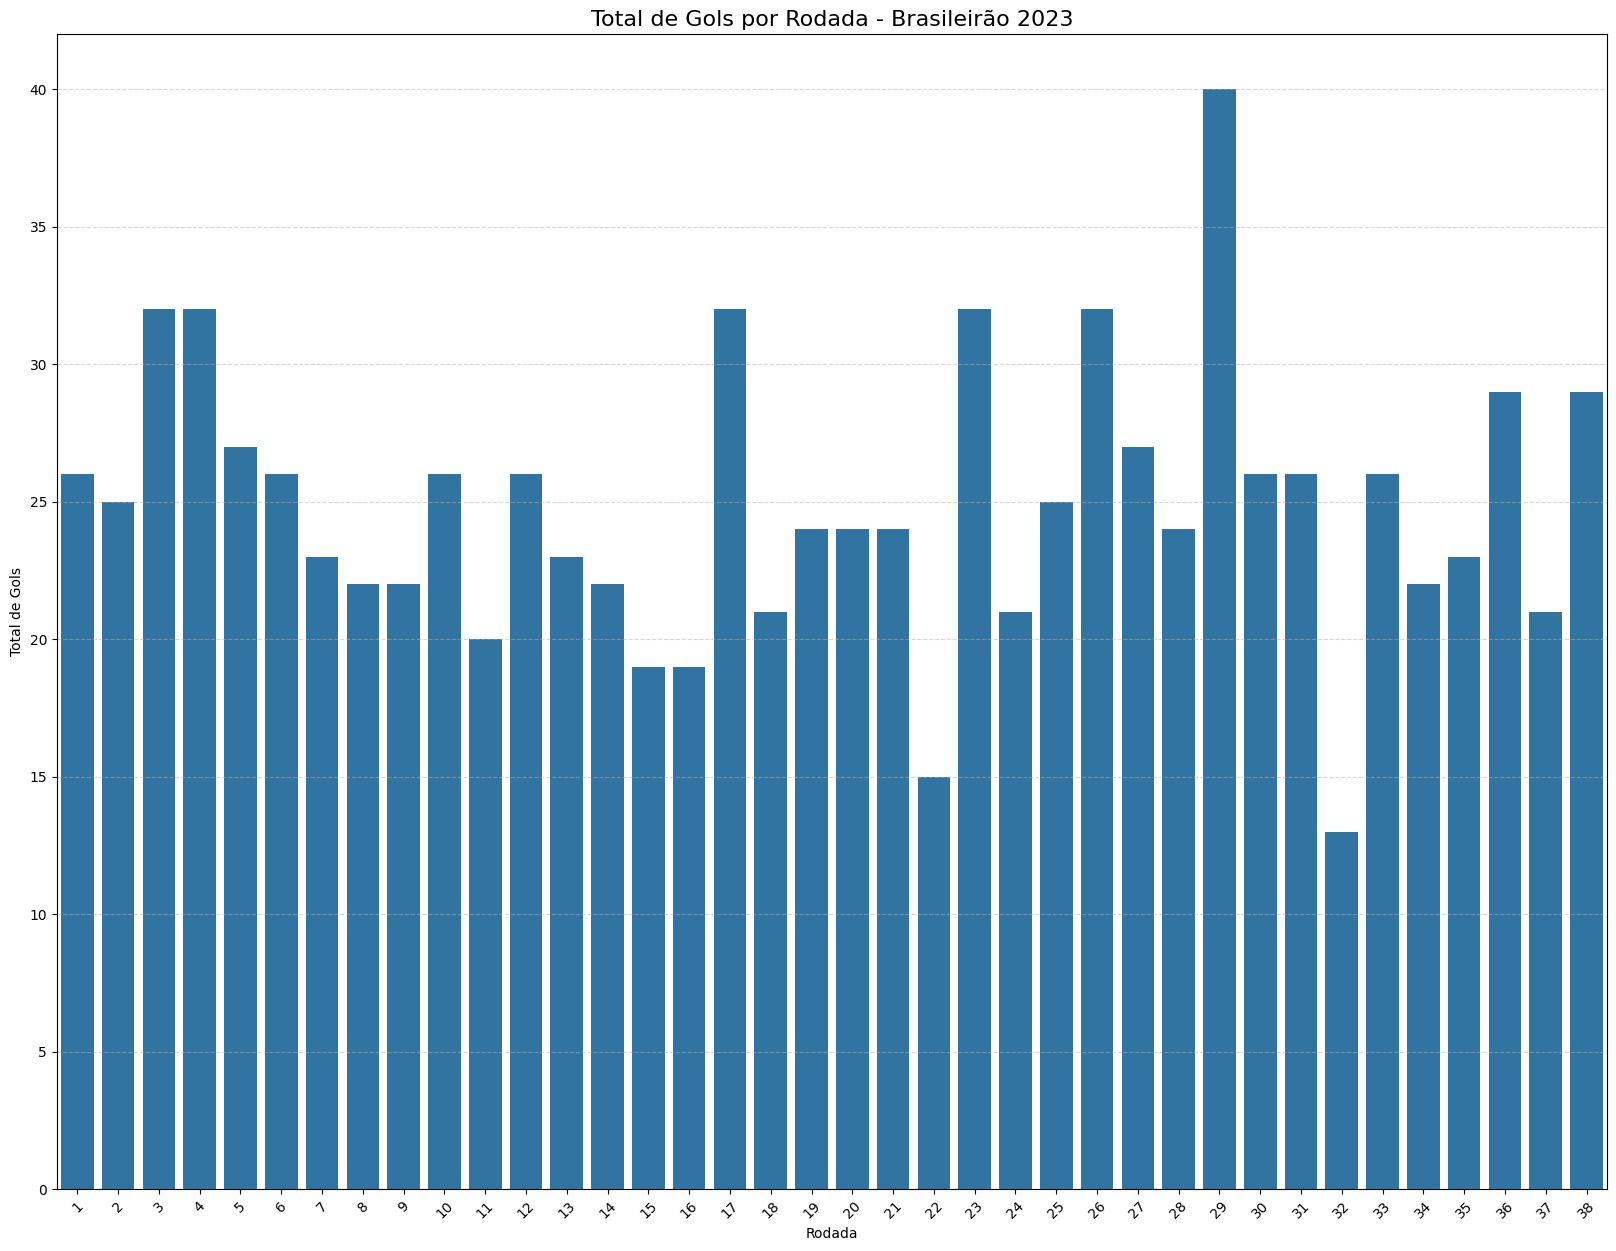

In [ ]:
plt.figure(figsize=(20,15))
sns.barplot(data=df_round_goals, x="rodada_num", y="total_goals")
plt.title("Total de Gols por Rodada - Brasileirão 2023", fontsize=16)
plt.xlabel("Rodada")
plt.ylabel("Total de Gols")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

In [79]:
df_matchs = df[["teams.home.name", "teams.away.name", "goals.home", "goals.away", "league.round"]].copy()
df_matchs["round"] = df_matchs["league.round"].str.extract(r"(\d+)").astype(int)

teams_list = {}

for _, row in df_matchs.iterrows():
    home = row["teams.home.name"]
    away = row["teams.away.name"]
    g_home = row["goals.home"]
    g_away = row["goals.away"]
    round_ = row["round"]

    for team, scored, conceded in [
        (home, g_home, g_away),
        (away, g_away, g_home)
    ]:
        if team not in teams_list:
            teams_list[team] = []
        teams_list[team].append({
            "team": team,
            "round": round_,
            "goals_scored": scored,
            "goals_conceded": conceded
        })

# Transforma corretamente em DataFrame
df_teams = pd.DataFrame([item for sublist in teams_list.values() for item in sublist])

df_teams.head(n=5)

,team,round,goals_scored,goals_conceded
0,Palmeiras,1,2,1
1,Palmeiras,2,2,2
2,Palmeiras,3,2,1
3,Palmeiras,4,5,0
4,Palmeiras,5,4,1


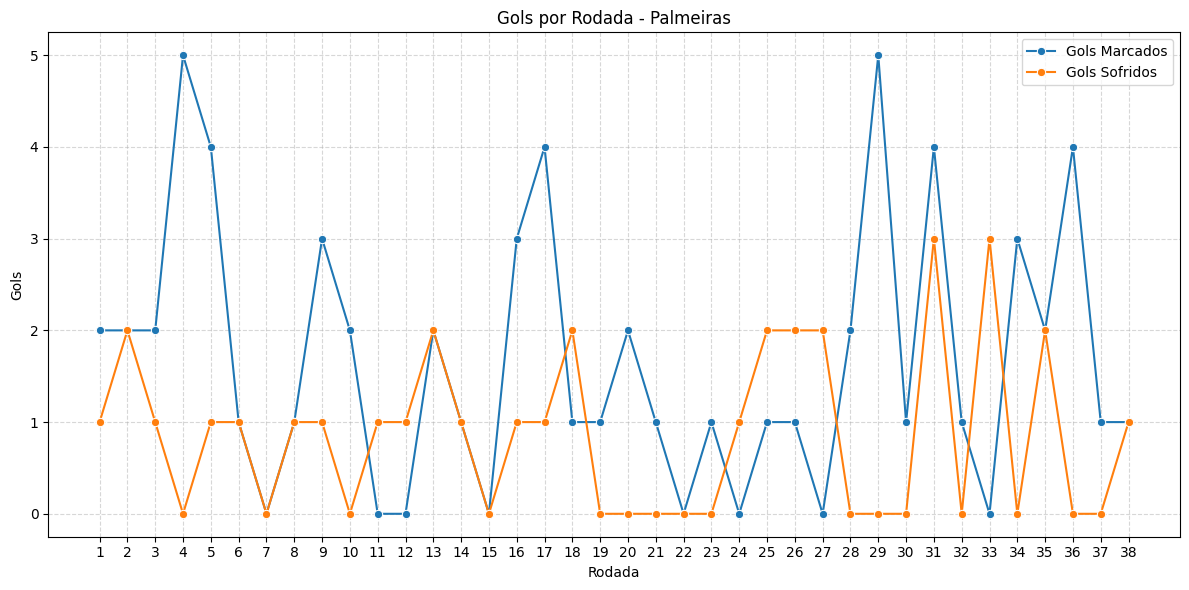

In [80]:
df_grouped = df_teams.groupby(["team", "round"])[["goals_scored", "goals_conceded"]].sum().reset_index()

# Filtra os dados só para esse time
df_time = df_grouped[df_grouped["team"] == "Palmeiras"]

# Cria o gráfico
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_time, x="round", y="goals_scored", label="Gols Marcados", marker="o")
sns.lineplot(data=df_time, x="round", y="goals_conceded", label="Gols Sofridos", marker="o")

plt.title(f"Gols por Rodada - Palmeiras")
plt.xlabel("Rodada")
plt.ylabel("Gols")
plt.xticks(range(1, df_time["round"].max()+1))
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()